# LAB 6 - CART II

In part I, we practiced:
- 1. training a classification tree;
- 2. changing complexity paramter to prune the tree;
- 3. addressing the class imbalance with the help of a custom loss function.

However, what is the best complexity paramter for our CART model?

This week, we will practice an important technique -- **cross-validation (CV)**-- to decide the best complexity paramter. In general, we consider the complexity paramter a hyperparameter. CV is a powerful way to fine tune the hyperparameters of our model.

We will introduce functions to perform Cross-validation (`GridSearchCV`) on our learners to yield better generalizing models and to help us select the best hyperparameters.

In [1]:
import numpy as np
import pandas as pd

## 1. CLASSIFICATION TREES

### Data Preprocessing from Last Week

In [2]:
parole = pd.read_csv("NYCparole.csv")
parole.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6102 entries, 0 to 6101
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Violator    6102 non-null   int64  
 1   Male        6102 non-null   int64  
 2   Age         6102 non-null   float64
 3   TimeServed  6102 non-null   float64
 4   Class       6102 non-null   object 
 5   Multiple    6102 non-null   int64  
 6   InCity      6102 non-null   int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 333.8+ KB


In [22]:
# transformation of data types
parole['Violator'] = parole['Violator'].astype('int64')
parole_enc = pd.get_dummies(parole, columns = ['Class'])

In [23]:
parole_enc.head(5)

,Violator,Male,Age,TimeServed,Multiple,InCity,Class_A,Class_B,Class_C,Class_D,Class_E
0,0,1,49.4,3.15,0,1,0,0,0,1,0
1,1,1,26.0,5.95,1,0,0,0,0,1,0
2,0,1,24.9,2.25,1,0,0,0,0,1,0
3,0,1,52.1,29.22,0,0,1,0,0,0,0
4,0,1,35.9,12.78,1,1,1,0,0,0,0


In [24]:
from sklearn.model_selection import train_test_split

y = parole_enc['Violator']
X = parole_enc.drop(['Violator'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,  
                                                    stratify=parole_enc['Violator'],
                                                    random_state=88,)
X_train.shape, X_test.shape

((4271, 10), (1831, 10))

### Decision Tree Classifier

`skelarn`'s `DecisionTreeClassifier` is just one of many implementations that we can use for our classification problem

In [6]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [7]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score 

#### Precision score and recall score

1. `Precision` focuses on the quality of positive predictions and answers the question: "Of all the instances predicted as positive, how many were actually positive?"

2. `Recall` focuses on the ability to find and capture all positive instances and answers the question: "Of all the actual positive instances, how many were correctly predicted?"

Node count = 15


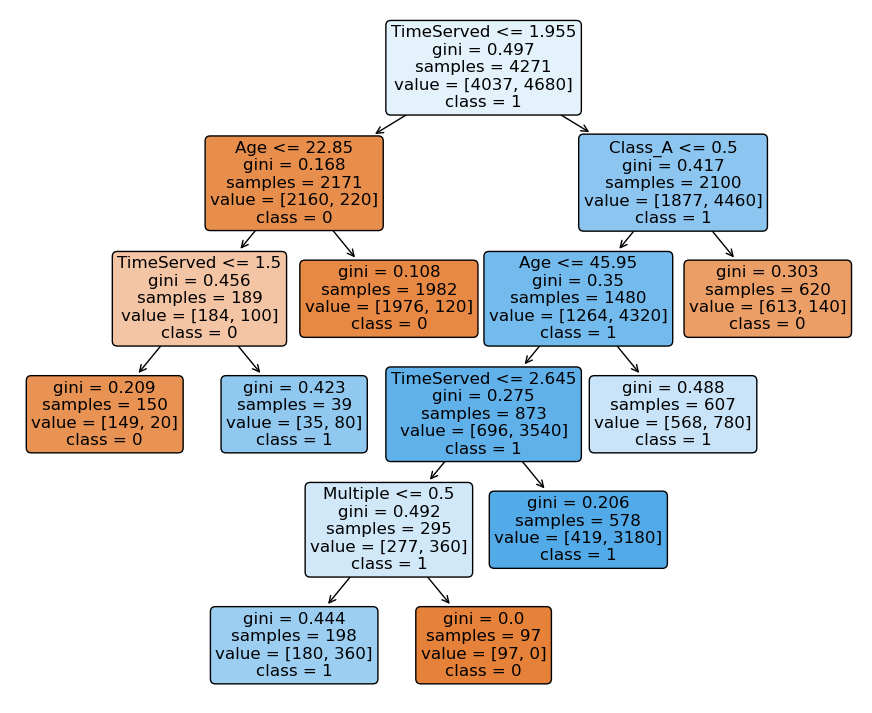

Confusion Matrix : 
 [[1219  511]
 [   7   94]]
Precision: 0.15537190082644628
Recall: 0.9306930693069307


In [8]:
dtc3 = DecisionTreeClassifier(min_samples_leaf=5, 
                              ccp_alpha=0.005,
                              class_weight = {0: 1, 1: 20},# Seting L_FN and L_FP
                              random_state = 88)# Question: why is this needed?

dtc3 = dtc3.fit(X_train, y_train)
# Note: the classification tree is trained using a process called recursive binary splitting

print('Node count =', dtc3.tree_.node_count)
plt.figure(figsize=(11,9))
plot_tree(dtc3, 
          feature_names=X_train.columns, 
          class_names=['0','1'], 
          filled=True,
          impurity=True,
          rounded=True,
          fontsize=12) 
plt.show()

y_pred = dtc3.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print ("Confusion Matrix : \n", cm) 
print('Precision:',precision_score(y_test, y_pred))
print('Recall:',recall_score(y_test, y_pred))

## 2. CROSS-VALIDATION

### 2.1 Cross-validation

In the below example, we are including additional hyperparmeters:

* `ccp_alpha`: complexity parameter (cp) used for pruning
* `min_samples_leaf`: The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it has at least min_samples_leaf training samples in each of the left and right branches.
* `min_samples_split`: The minimum number of samples required to split an internal node
* `max_depth`: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
* `class_weight`: Associated weights for each class in a `dict` format

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold


grid_values = {'ccp_alpha': np.linspace(0, 0.10, 201),# the choice of alpha, ranging from 0 to 0.2
               'min_samples_leaf': [5],
               'min_samples_split': [20],
               'max_depth': [30],
               'class_weight' : [{0: 1, 1: 20}],
               'random_state': [88]}

            
dtc = DecisionTreeClassifier()

### Note that the line below is important. It ensures that the training data is split into
### five folds randomly. 
### By default, gridSearchCV will split the training data without shuffling. 
cv = KFold(n_splits=5,random_state=1,shuffle=True) 
### by setting random_state as a fixed number, we ensure that each time the GridSearchCV splits data, 
### we get the same split.

dtc_cv_acc = GridSearchCV(dtc, param_grid = grid_values, scoring = 'accuracy', cv=cv, verbose=1) 
# default scoring metric to optimize the accuracy
# cv = k-fold, k=10; default cv=5;
dtc_cv_acc.fit(X_train, y_train)

Fitting 5 folds for each of 201 candidates, totalling 1005 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([0.    , 0.0005, 0.001 , 0.0015, 0.002 , 0.0025, 0.003 , 0.0035,
       0.004 , 0.0045, 0.005 , 0.0055, 0.006 , 0.0065, 0.007 , 0.0075,
       0.008 , 0.0085, 0.009 , 0.0095, 0.01  , 0.0105, 0.011 , 0.0115,
       0.012 , 0.0125, 0.013 , 0.0135, 0.014 , 0.0145, 0.015 , 0.0155,
       0.016 , 0.0165, 0.017...
       0.084 , 0.0845, 0.085 , 0.0855, 0.086 , 0.0865, 0.087 , 0.0875,
       0.088 , 0.0885, 0.089 , 0.0895, 0.09  , 0.0905, 0.091 , 0.0915,
       0.092 , 0.0925, 0.093 , 0.0935, 0.094 , 0.0945, 0.095 , 0.0955,
       0.096 , 0.0965, 0.097 , 0.0975, 0.098 , 0.0985, 0.099 , 0.0995,
       0.1   ]),
                         'class_weight': [{0: 1, 1: 20}], 'max_depth': [30],
                         'min_samples_leaf': [5], 'min_samples_split': [20],
                         'random_state': [88]},
             scoring='accuracy', verbose=1)

In [10]:
acc = dtc_cv_acc.cv_results_['mean_test_score'] 
# what sklearn calls mean_test_score is the holdout set, i.e. the validation set.
ccp = dtc_cv_acc.cv_results_['param_ccp_alpha'].data

pd.DataFrame({'ccp alpha' : ccp, 'Validation Accuracy': acc}).head(20)

,ccp alpha,Validation Accuracy
0,0.0,0.843363
1,0.0005,0.843597
2,0.001,0.841723
3,0.0015,0.823229
4,0.002,0.811516
5,0.0025,0.789506
6,0.003,0.769601
7,0.0035,0.762813
8,0.004,0.759533
9,0.0045,0.753209


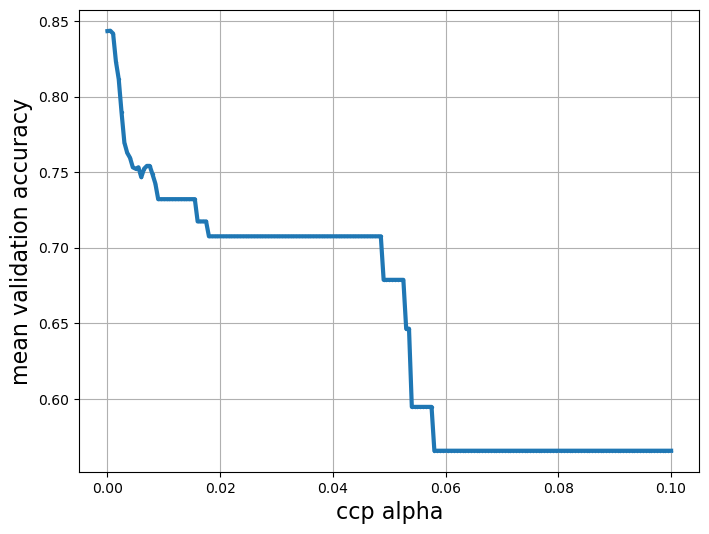

In [11]:
plt.figure(figsize=(8, 6))
plt.xlabel('ccp alpha', fontsize=16)
plt.ylabel('mean validation accuracy', fontsize=16)
plt.scatter(ccp, acc, s=2)
plt.plot(ccp, acc, linewidth=3)
plt.grid(True, which='both')
plt.show()

In [12]:
print('Grid best parameter ccp_alpha (max. accuracy): ', dtc_cv_acc.best_params_['ccp_alpha'])
print('Grid best score (accuracy): ', dtc_cv_acc.best_score_)

Grid best parameter ccp_alpha (max. accuracy):  0.0005
Grid best score (accuracy):  0.8435969705684977


Node count = 179


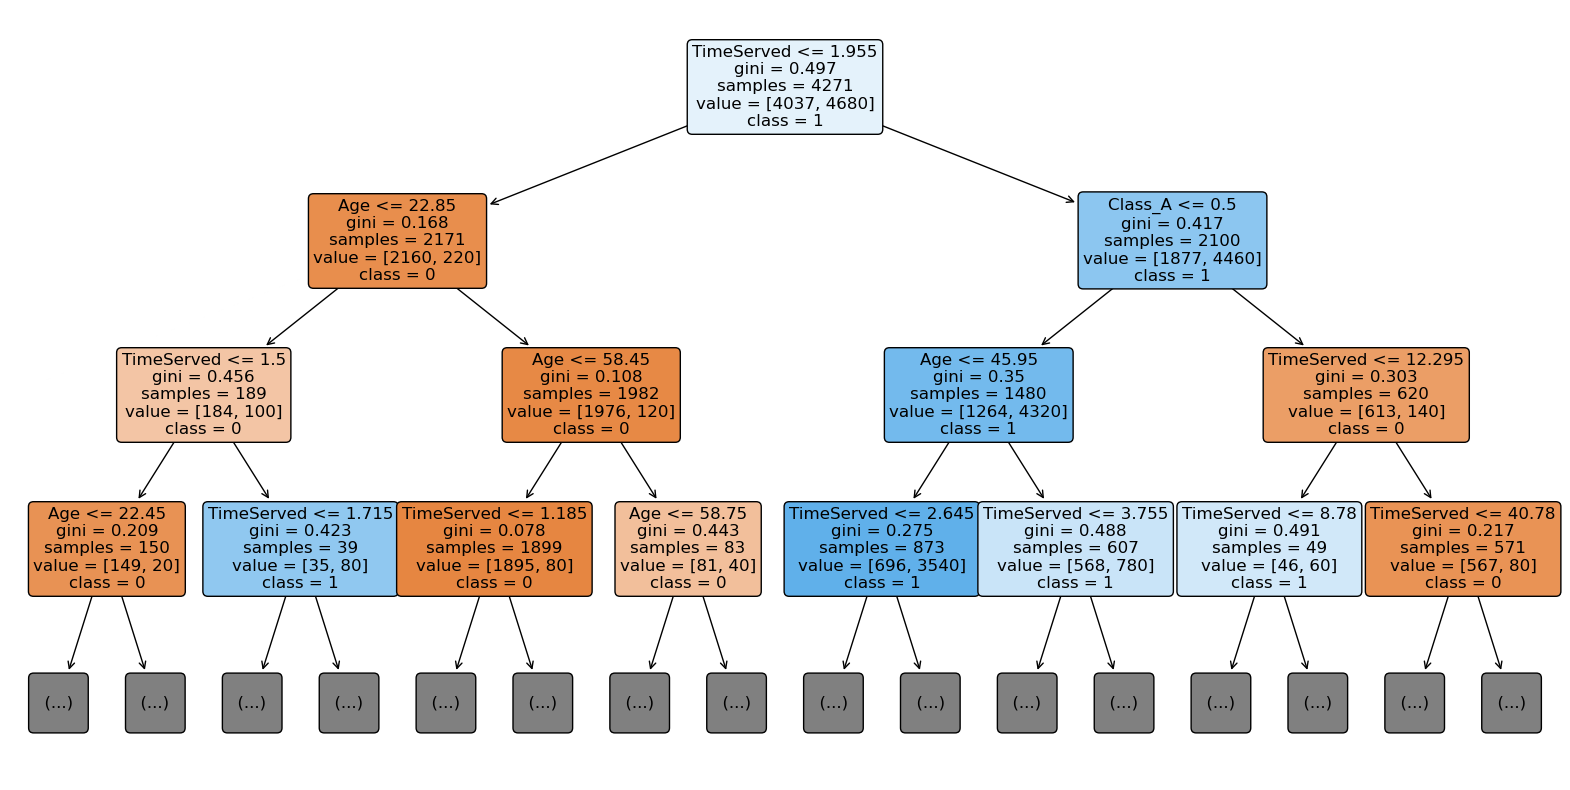

In [13]:
print('Node count =', dtc_cv_acc.best_estimator_.tree_.node_count)

plt.figure(figsize=(20,10))
plot_tree(dtc_cv_acc.best_estimator_, 
          feature_names=X_train.columns, 
          class_names=['0','1'],
          filled=True,
          impurity=True,
          rounded=True,
          fontsize=12,
          max_depth=3)
plt.show()

In [14]:
y_pred = dtc_cv_acc.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix : \n", cm)
print('Precision:',precision_score(y_test, y_pred))
print('Recall:',recall_score(y_test, y_pred))

Confusion Matrix : 
 [[1461  269]
 [  28   73]]
Precision: 0.2134502923976608
Recall: 0.7227722772277227


### 2.2 Cross-validation with Custom Loss Function

In [15]:
def average_loss_function(y_test, y_pred):
    
    weights = np.array([20 if i == 1 else 1 for i in y_test])
    
    return np.mean(weights*(y_test != y_pred))

In [16]:
from sklearn.metrics import make_scorer          

dtc = DecisionTreeClassifier()

### Note that the line below is important. It ensures that the training data is split into
### five folds randomly. Recall what we've seen in the discussion slides that by default,
### GridSearchCV will split the training data without shuffling. 
cv = KFold(n_splits=5,random_state=1,shuffle=True) 
### by setting random_state as a fixed number, we ensure that each time the GridSearchCV splits data, 
### we get the same split.

dtc_cv_avgloss = GridSearchCV(dtc, param_grid = grid_values, cv=cv, verbose=1,
                              scoring = make_scorer(average_loss_function, greater_is_better=False))
dtc_cv_avgloss.fit(X_train, y_train)

Fitting 5 folds for each of 201 candidates, totalling 1005 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([0.    , 0.0005, 0.001 , 0.0015, 0.002 , 0.0025, 0.003 , 0.0035,
       0.004 , 0.0045, 0.005 , 0.0055, 0.006 , 0.0065, 0.007 , 0.0075,
       0.008 , 0.0085, 0.009 , 0.0095, 0.01  , 0.0105, 0.011 , 0.0115,
       0.012 , 0.0125, 0.013 , 0.0135, 0.014 , 0.0145, 0.015 , 0.0155,
       0.016 , 0.0165, 0.017...
       0.088 , 0.0885, 0.089 , 0.0895, 0.09  , 0.0905, 0.091 , 0.0915,
       0.092 , 0.0925, 0.093 , 0.0935, 0.094 , 0.0945, 0.095 , 0.0955,
       0.096 , 0.0965, 0.097 , 0.0975, 0.098 , 0.0985, 0.099 , 0.0995,
       0.1   ]),
                         'class_weight': [{0: 1, 1: 20}], 'max_depth': [30],
                         'min_samples_leaf': [5], 'min_samples_split': [20],
                         'random_state': [88]},
             scoring=make_scorer(average_loss_function, greater_is_better=False),
             verbose=1)

`make_scorer` is a sklearn wrapper function that takes in a default sklearn scoring function (i.e. `accuracy_score`) or a custom scoring/loss function and returns a callable that scores an estimator’s output. This is a useful method that wraps your custom scoring functions for use in GridSearchCV. 

For more information, refer to the following documentation:
* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html
* https://scikit-learn.org/stable/modules/model_evaluation.html#scoring

In [17]:
ccp = dtc_cv_avgloss.cv_results_['param_ccp_alpha'].data
mean_avgloss = dtc_cv_avgloss.cv_results_['mean_test_score']*(-1) 
# sklearn uses the negative of the loss as an objective function to maximize, 
# rather than implementation a minimization scheme
pd.DataFrame({'ccp alpha' : ccp, 'Mean Validation Average Loss': mean_avgloss}).head()

,ccp alpha,Mean Validation Average Loss
0,0.0,0.508097
1,0.0005,0.503413
2,0.001,0.496387
3,0.0015,0.470391
4,0.002,0.446506


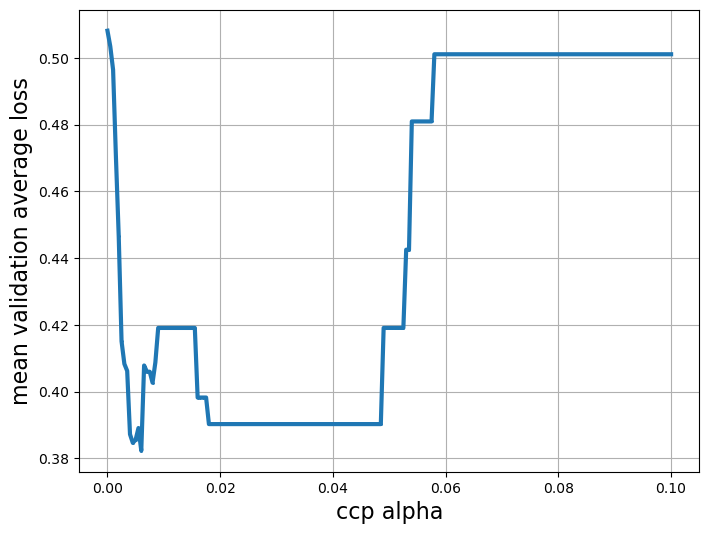

In [18]:
plt.figure(figsize=(8, 6))
plt.xlabel('ccp alpha', fontsize=16)
plt.ylabel('mean validation average loss', fontsize=16)
plt.scatter(ccp, mean_avgloss, s=1)
plt.plot(ccp, mean_avgloss, linewidth=3)
plt.grid(True, which='both')
plt.show()

In [19]:
print('Grid best parameter (min. Avg Loss): ', dtc_cv_avgloss.best_params_['ccp_alpha'])
print('Grid best score (Avg Loss): ', dtc_cv_avgloss.best_score_*(-1))

Grid best parameter (min. Avg Loss):  0.006
Grid best score (Avg Loss):  0.3823249380281304


Node count = 11


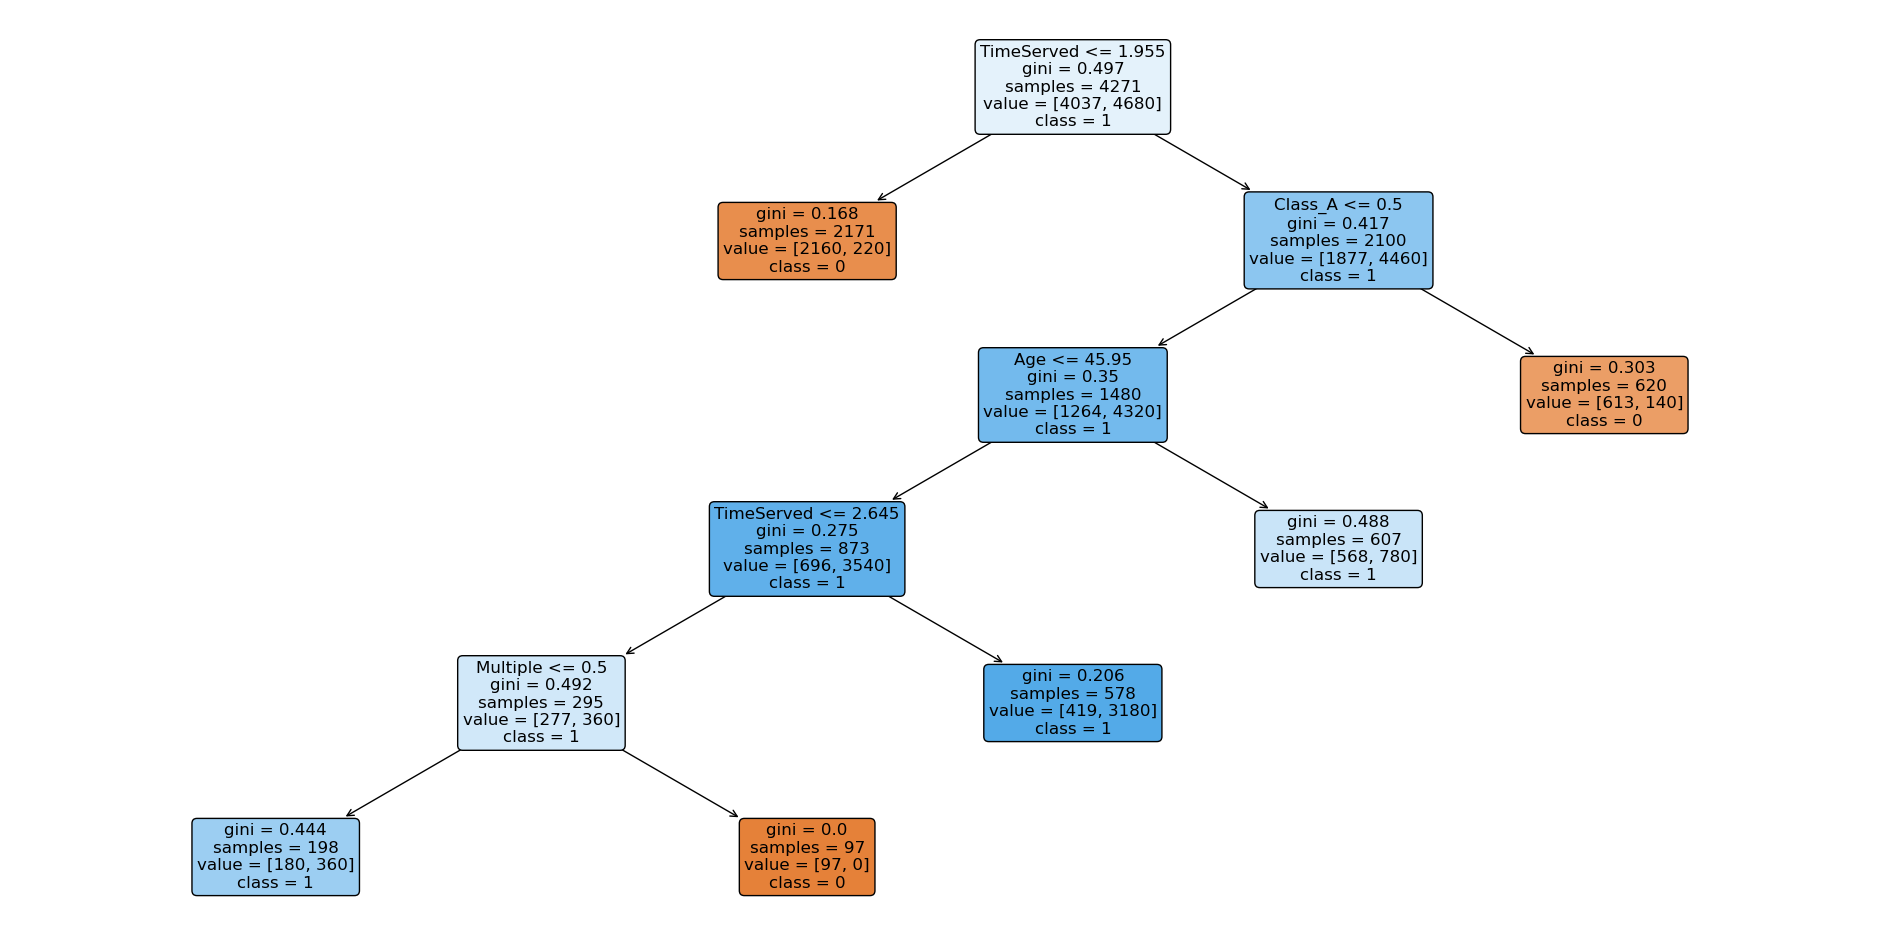

In [20]:
print('Node count =', dtc_cv_avgloss.best_estimator_.tree_.node_count)

plt.figure(figsize=(24,12))
plot_tree(dtc_cv_avgloss.best_estimator_, 
          feature_names=X_train.columns, 
          class_names=['0','1'], 
          filled=True,
          impurity=True,
          rounded=True,
          fontsize=12)
plt.show()

In [21]:
y_pred = dtc_cv_avgloss.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print ("Confusion Matrix : \n", cm)
print('Precision:',precision_score(y_test, y_pred))
print('Recall:',recall_score(y_test, y_pred))

Confusion Matrix : 
 [[1239  491]
 [   7   94]]
Precision: 0.1606837606837607
Recall: 0.9306930693069307
